# CatBoost with cross-validated optimization

**Example using the catboost_auto function in the PyMLR module**

The **catboost_auto** function automatically finds the optimum set of cross-validated hyper-parameters and then outputs the fitted regression model and summary statistics using CatBoost with optuna.

The **catboost_auto** function preprocesses X by default to standardize continuous features and one-hot encode categorical features. 

This example shows how to check the cross-validation of the model with independent training and testing data subsets before fitting the final model with all of the data.

#### Example data set

This example uses the diabetes dataset by sklearn

Before running this notebook, first install the PyMLR module in your environment, if it is not already installed, using the following line in the next cell:

In [1]:
# !pip install git+https://github.com/gjpelletier/PyMLR.git --upgrade

## Read X and y from the sklearn diabetes data set

In [2]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True, as_frame=True)

## Split X and y into cross-validation train and test subsets

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the model with the training data subset

In the next step, we will automatically find the best cross-validated hyper-parameters for CatBoost using optuna. Then we will fit the model using the training data with the best parameters. 

After this training step is completed, proceed to the next step to check how well the predictions from the training data match the predictions using the testing data. 

Running optuna to find best parameters, could take a few minutes, please wait...
Fitting CatBoostRegressor model with best parameters, please wait ...

CatBoostRegressor goodness of fit to training data in model_outputs['stats']:

| Statistic          |   CatBoostRegressor |
|:-------------------|--------------------:|
| R-squared          |            0.7191   |
| MSE                |         1706.86     |
| RMSE               |           41.3141   |
| Explained Variance |            0.719106 |
| MAE                |           33.9451   |
| Max Error          |          114.628    |
| MAPE               |            0.302941 |
| MSLE               |            0.110005 |
| n_samples          |          353        |

Done
Time elapsed: 879.11 sec



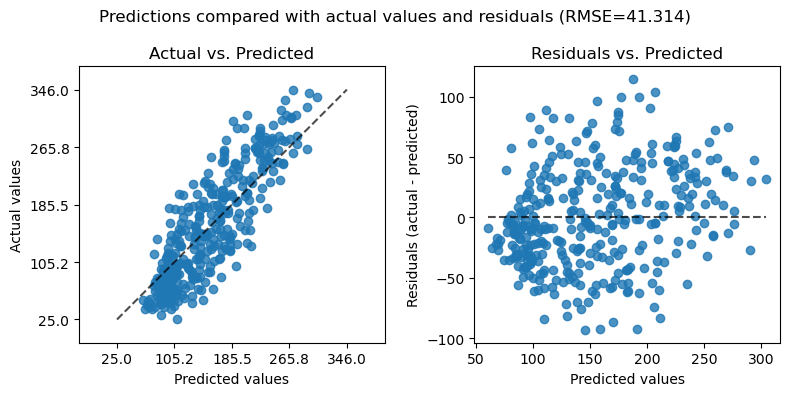

In [4]:
kwargs = {
    'random_state': 42,                 # random seed for reproducibility
    'n_trials': 50,                     # number of optuna trials
    'learning_rate': [0.01, 0.3],       # Balances step size in gradient updates.
    'depth': [4, 10],                   # Controls tree depth
    'iterations': [100, 3000],          # Number of boosting iterations
    'l2_leaf_reg': [1, 10],             # Regularization strength       
    'random_strength': [0, 1],          # Adds noise for diversity
    'bagging_temperature': [0.1, 1.0],  # Controls randomness in sampling
    'border_count': [32, 255],          # Number of bins for feature discretization
    'min_data_in_leaf': [1, 100],       # Minimum samples per leaf         
    'max_bin': [64, 255],               # Number of bins for feature quantization
    }    

from PyMLR import catboost_auto
train_model, train_output = catboost_auto(X_train, y_train, **kwargs)

## Test the model with the testing data subset

In the next step we will check how well the predictions from fitted model match samples from the testing data. To standardize the testing data we will use the same preprocess_result scaler that was used to standardize the training data to avoid data leakage between the training and testing data. We will also use the same optimized selected features that were determined during the training.


Goodness of fit to testing data in result['metrics']:

| Statistic          |   Regressor |
|:-------------------|------------:|
| R-squared          |    0.502521 |
| MSE                | 2635.72     |
| RMSE               |   51.3393   |
| Explained Variance |    0.502521 |
| MAE                |   41.073    |
| Max Error          |  154.371    |
| MAPE               |    0.375589 |
| MSLE               |    0.161268 |
| n_samples          |   89        |



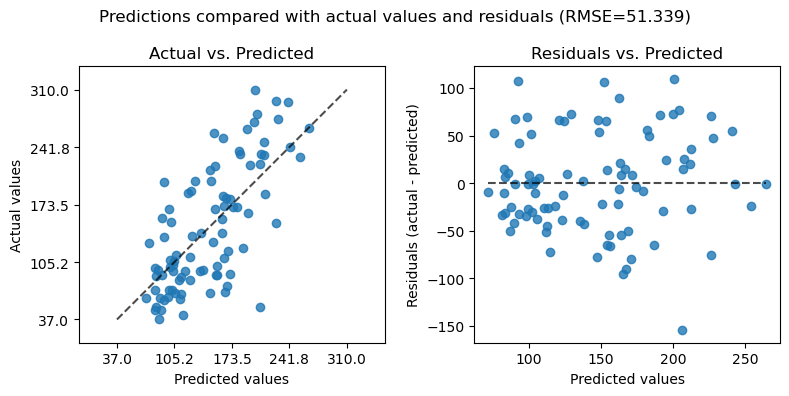

In [5]:
from PyMLR import test_model
test_output = test_model(train_model, X_test, y_test, 
    preprocess_result= train_output['preprocess_result'],
    selected_features= train_output['selected_features'])

# save the plot of predictions vs actual and residuals
test_output['fig'].savefig("CatBoostRegressor_predictions_test.png", dpi=300)

## Final fit of the model using all of the X and y data

In the next step we will use the optimum hyperparameters and selected features from the training model and fit the model using all of the X and y data. The standard scaler and encoder are recalculated by default (the user also has the option to input a previously calculated scaler/encoder from a previous preprocess_result).

Fitting CatBoostRegressor model, please wait ...


CatBoostRegressor goodness of fit to training data in model_outputs['stats']:

| Statistic          |   CatBoostRegressor |
|:-------------------|--------------------:|
| R-squared          |            0.689874 |
| MSE                |         1839.01     |
| RMSE               |           42.8837   |
| Explained Variance |            0.689876 |
| MAE                |           34.8183   |
| Max Error          |          137.524    |
| MAPE               |            0.312965 |
| MSLE               |            0.117214 |
| n_samples          |          442        |

Done
Time elapsed: 0.66 sec



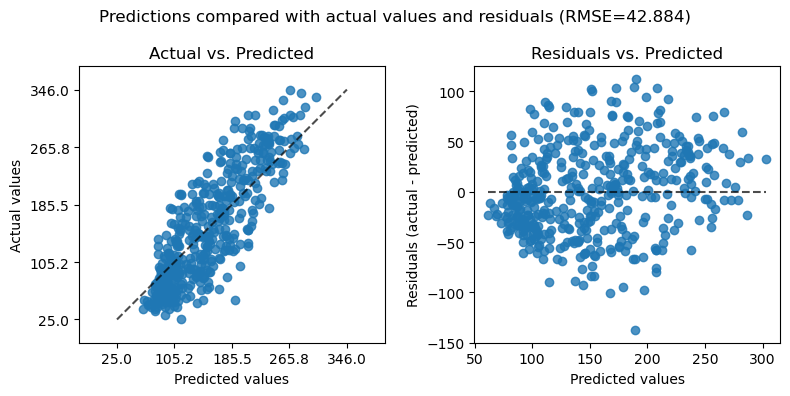

In [7]:
from PyMLR import catboost
final_model, final_output = catboost(X, y, 
    **train_output['best_params'],
    selected_features= train_output['selected_features'])

## Display the results of the hyperparameter optimization

The results of the optuna optimization study were saved in the previous step when the model was trained with the training data subset. The output dictionary that we called **train_output** in that step contains a key named **optuna_study** which contains the results of the optimized optuna study. 

In the next step we will use the **show_optuna** function to display the results of the optimized cross-validated optuna study to show the selected optimum values for the hyperparameters, the optimization history, and the relationships between the hyperparameters and their importance for the scoring criteria.

Best parameters:

learning_rate: 0.02012769759967112
depth: 5
iterations: 257
l2_leaf_reg: 1.695942712837536
random_strength: 0.9269853128754446
bagging_temperature: 0.818258198676408
min_data_in_leaf: 44
grow_policy: SymmetricTree
use_border_count: True
border_count: 33
num_features: 11
selector_type: mutual_info

Best score: -57.02107248898661



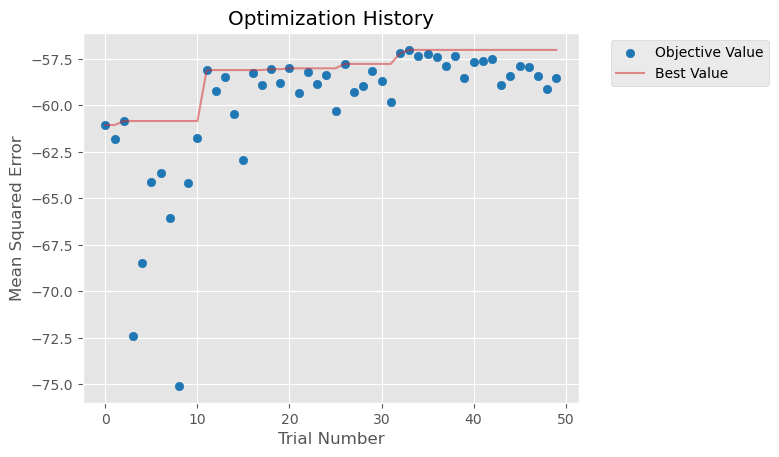

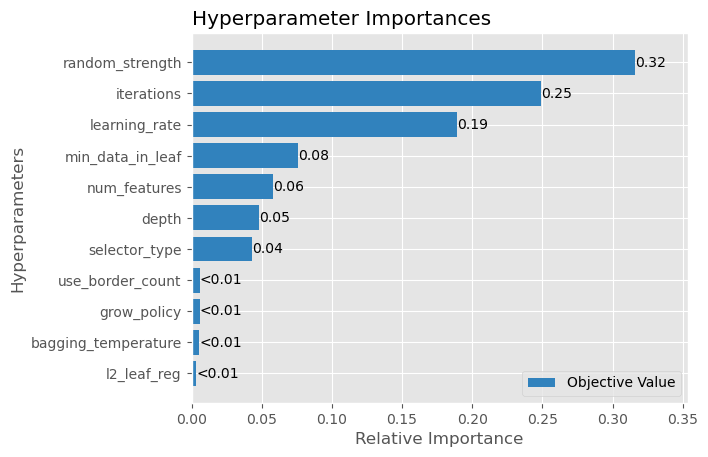

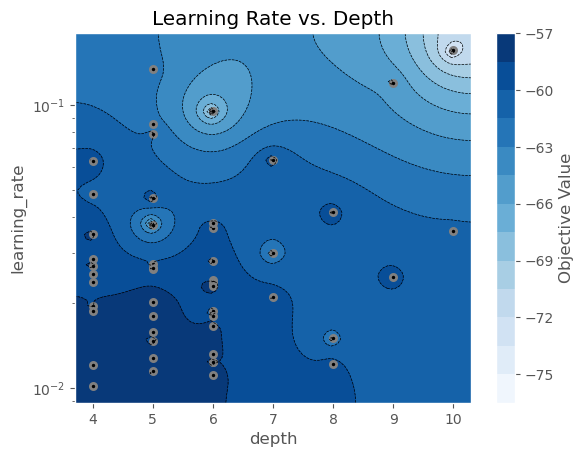

In [8]:
from PyMLR import show_optuna
show_optuna(train_output['optuna_study'])

## User instructions

In [9]:
help(catboost_auto)

Help on function catboost_auto in module PyMLR:

catboost_auto(X, y, **kwargs)
    Autocalibration of CatBoostRegressor hyper-parameters
    Beta version

    by
    Greg Pelletier
    gjpelletier@gmail.com
    29-June-2025

    REQUIRED INPUTS (X and y should have same number of rows and
    only contain real numbers)
    X = dataframe of the candidate independent variables
        (as many columns of data as needed)
    y = dataframe of the dependent variable (one column of data)

    OPTIONAL KEYWORD ARGUMENTS
    **kwargs (optional keyword arguments):
        random_state= 42,    # initial random seed
        n_trials= 50,         # number of optuna trials
        preprocess= True,           # Apply OneHotEncoder and StandardScaler
        preprocess_result= None,    # dict of the following result from
                                    # preprocess_train if available:
                                    # - encoder          (OneHotEncoder)
                                    # - 